In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns
import os
import pandas as pd
from tqdm import tqdm
import numpy as np


In [2]:
directory = "sae-auto-interp"

In [3]:
def score_prfa(dataframe,inverse=False):
    #True positive when data["activates"]==True and data["marked"]==True
    #False positive when data["activates"]==True and data["marked"]==False
    #True negative when data["activates"]==False and data["marked"]==False
    #False negative when data["activates"]==False and data["marked"]==True

    tp = len(dataframe[(dataframe["activates"]==True) & (dataframe["marked"]==True)])
    fp = len(dataframe[(dataframe["activates"]==False) & (dataframe["marked"]==True)])
    tn = len(dataframe[(dataframe["activates"]==False) & (dataframe["marked"]==False)])
    fn = len(dataframe[(dataframe["activates"]==True) & (dataframe["marked"]==False)])
    if inverse:
        tp,fp,tn,fn = tn,fn,tp,fp
    if tp+fp == 0:
        precision = 0
    else:
        precision = tp/(tp+fp)
    if tp+fn == 0:
        recall = 0
    else:
        recall = tp/(tp+fn)
    if precision+recall == 0:
        f1 = 0
    else:
        f1 = 2*(precision*recall)/(precision+recall)
    if tn+fp == 0:
        balanced_accuracy = 0
    else:
        balanced_accuracy = (recall+tn/(tn+fp))/2
    return precision, recall, f1, balanced_accuracy

In [4]:
def score_right(dataframe):
    tp = len(dataframe[(dataframe["activates"]==True) & (dataframe["marked"]==True)])
    tn = len(dataframe[(dataframe["activates"]==False) & (dataframe["marked"]==False)])
    right = tp+tn
    if len(dataframe) == 0:
        return 0
    return right/len(dataframe)

def estimate_errorbars_right(dataframe, num_iterations=10):
    scores = []
    
    for _ in range(num_iterations):
        # Sample the data with replacement
        data = dataframe.sample(frac=0.2, replace=True)
        # Call score_right with the shuffled data
        score = score_right(data)
        scores.append(score)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    return mean_score, std_score

In [5]:
def analyse(directory,number_files=1000):
    all_data = []
    counter = 0
    for filename in tqdm(os.listdir(directory)):
        if filename.endswith('.txt'):
            counter += 1
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                data = json.load(file)
            for d in data:
                d.pop('text')
                d["counter"]=counter
            all_data.extend(data)
            if counter >= number_files:
                break

            
    data_df = pd.DataFrame(all_data)
    detector = data_df[data_df["highlighted"]==False]
    fuzzing = data_df[data_df["highlighted"]==True]
    per_quantile_agregate_detector = []
    per_quantile_agregate_fuzzing = []
    
    per_quantile_agregate_detector.append(estimate_errorbars_right(detector))
    per_quantile_agregate_fuzzing.append(estimate_errorbars_right(fuzzing))
    for i in range(5):
        q = i-1
        quantile = detector[detector["quantile"]==q]
        per_quantile_agregate_detector.append(estimate_errorbars_right(quantile))
        
        quantile = fuzzing[fuzzing["quantile"]==q]
        per_quantile_agregate_fuzzing.append(estimate_errorbars_right(quantile))
        
    individual_detector = {"precision":[],"recall":[],"f1":[], "balanced_accuracy":[]}
    individual_fuzzing = {"precision":[],"recall":[],"f1":[], "balanced_accuracy":[]}
    
    for i in range(1,counter+1):
        individual_scores = detector[detector["counter"]==i]
        precision, recall, f1,balanced_accuracy = score_prfa(individual_scores)
        individual_detector["precision"].append(precision)
        individual_detector["recall"].append(recall)
        individual_detector["f1"].append(f1)
        individual_detector["balanced_accuracy"].append(balanced_accuracy)

        individual_scores = fuzzing[fuzzing["counter"]==i]
        precision, recall, f1,balanced_accuracy = score_prfa(individual_scores)
        individual_fuzzing["precision"].append(precision)
        individual_fuzzing["recall"].append(recall)
        individual_fuzzing["f1"].append(f1)
        individual_fuzzing["balanced_accuracy"].append(balanced_accuracy)
    
    return np.array(per_quantile_agregate_detector), np.array(per_quantile_agregate_fuzzing), individual_detector, individual_fuzzing, data_df

# COT vs Simple

In [6]:
simple_results = analyse("scores/fuzz_local_simple")

100%|██████████| 94/94 [00:00<00:00, 4131.50it/s]


## Per quantile

([<matplotlib.axis.XTick at 0x7f84191b83d0>,
 [Text(0, 0, 'Overall'),
  Text(1, 0, 'Non activating'),
  Text(2, 0, 'Q1'),
  Text(3, 0, 'Q2'),
  Text(4, 0, 'Q3'),
  Text(5, 0, 'Q4')])

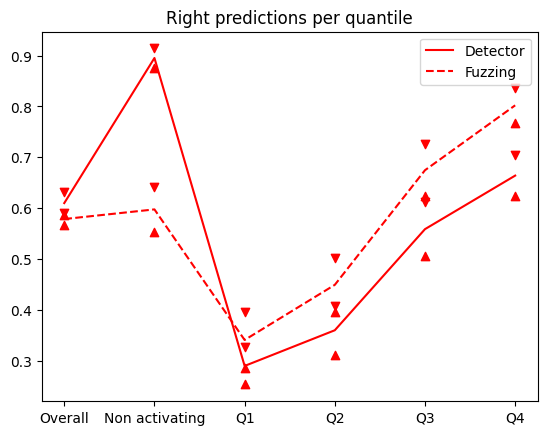

In [8]:
pqad, pqaf, id, ifu,cot_data = simple_results
plt.figure()

plt.plot(pqad[:,0], label="Detector",color="red")
plt.scatter([0,1,2,3,4,5],pqad[:,0]+pqad[:,1],color="red",marker="v")
plt.scatter([0,1,2,3,4,5],pqad[:,0]-pqad[:,1],color="red",marker="^")
plt.plot(pqaf[:,0], label="Fuzzing",color="red",linestyle="--")
plt.scatter([0,1,2,3,4,5],pqaf[:,0]+pqaf[:,1],color="red",marker="v")
plt.scatter([0,1,2,3,4,5],pqaf[:,0]-pqaf[:,1],color="red",marker="^")

plt.legend()
plt.title("Right predictions per quantile")
plt.xticks([0,1,2,3,4,5],["Overall","Non activating","Q1","Q2","Q3","Q4"])


## Histogram

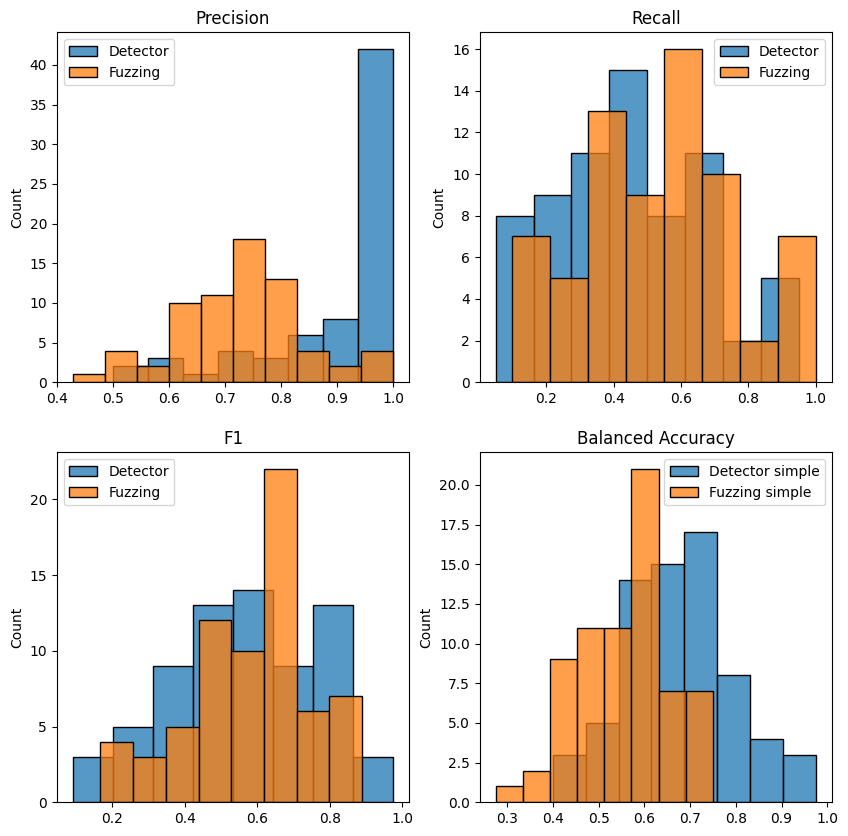

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
precision = [id["precision"], ifu["precision"]]
recall = [id["recall"], ifu["recall"]]
f1 = [id["f1"], ifu["f1"]]
balanced_accuracy = [id["balanced_accuracy"], ifu["balanced_accuracy"]]

labels = ["Detector", "Fuzzing"]

for i in range(2):
    sns.histplot(precision[i], ax=ax[0][0], label=labels[i])
ax[0][0].set_title("Precision")
ax[0][0].legend()

for i in range(2):
    sns.histplot(recall[i], ax=ax[0][1], label=labels[i])
ax[0][1].set_title("Recall")
ax[0][1].legend()

for i in range(2):
    sns.histplot(f1[i], ax=ax[1][0], label=labels[i])
ax[1][0].set_title("F1")
ax[1][0].legend()

for i in range(2):
    sns.histplot(balanced_accuracy[i - 2], ax=ax[1][1], label=labels[i])
ax[1][1].set_title("Balanced Accuracy")
ax[1][1].legend()

plt.show()

# Sampling techniques

In [260]:
short = analyse("scores/llama_short")
long = analyse("scores/llama_long")
short_100 = analyse("scores/llama_10_100")
short_all = analyse("scores/llama_10_all")
long_100 = analyse("scores/llama_20_100")
long_all = analyse("scores/llama_20_all")
long_mix = analyse("scores/llama_10_all_10")

100%|██████████| 250/250 [02:13<00:00,  1.87it/s]


Text(0, 0.5, 'Fraction right')

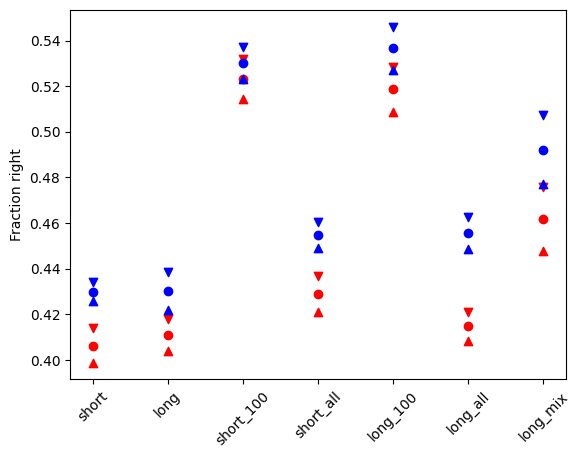

In [262]:
types = ["short","long","short_100","short_all","long_100","long_all","long_mix"]
results = [short,long,short_100,short_all,long_100,long_all,long_mix]
plt.figure()

for i,result in enumerate(results):
    pqad, pqaf, id, ifu,temp_data = result
    plt.scatter(i,pqad[0][0], label="Detector ",color="red")
    plt.scatter(i,pqad[0][0]+pqad[0][1],color="red",marker="v")
    plt.scatter(i,pqad[0][0]-pqad[0][1],color="red",marker="^")
    plt.scatter(i,pqaf[0][0], label="Fuzzing ",color="blue")
    plt.scatter(i,pqaf[0][0]+pqaf[0][1],color="blue",marker="v")
    plt.scatter(i,pqaf[0][0]-pqaf[0][1],color="blue",marker="^")
plt.xticks(range(len(types)),types,rotation=45)
plt.ylabel("Fraction right")

([<matplotlib.axis.XTick at 0x7f9993d5f550>,
 [Text(0, 0, 'Overall'),
  Text(1, 0, 'Non activating'),
  Text(2, 0, 'Q1'),
  Text(3, 0, 'Q2'),
  Text(4, 0, 'Q3'),
  Text(5, 0, 'Q4')])

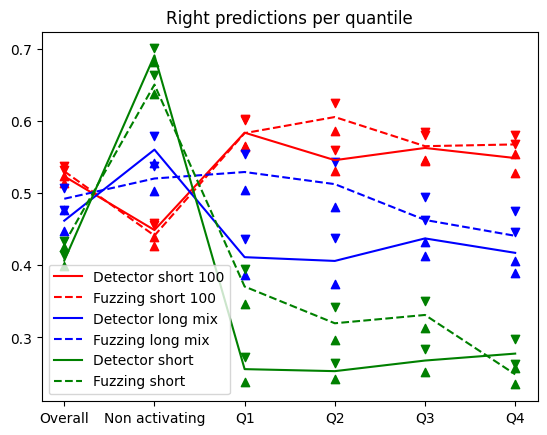

In [263]:
pqad, pqaf, id, ifu,cot_data = short_100
pqad_s, pqaf_s, id_s, ifu_s,simple_data = long_mix
pqad_ss, pqaf_ss, id_ss, ifu_ss,simple_data = short

plt.figure()

plt.plot(pqad[:,0], label="Detector short 100",color="red")
plt.scatter([0,1,2,3,4,5],pqad[:,0]+pqad[:,1],color="red",marker="v")
plt.scatter([0,1,2,3,4,5],pqad[:,0]-pqad[:,1],color="red",marker="^")
plt.plot(pqaf[:,0], label="Fuzzing short 100",color="red",linestyle="--")
plt.scatter([0,1,2,3,4,5],pqaf[:,0]+pqaf[:,1],color="red",marker="v")
plt.scatter([0,1,2,3,4,5],pqaf[:,0]-pqaf[:,1],color="red",marker="^")


plt.plot(pqad_s[:,0], label="Detector long mix",color="blue")
plt.scatter([0,1,2,3,4,5],pqad_s[:,0]+pqad_s[:,1],color="blue",marker="v")
plt.scatter([0,1,2,3,4,5],pqad_s[:,0]-pqad_s[:,1],color="blue",marker="^")
plt.plot(pqaf_s[:,0], label="Fuzzing long mix ",color="blue",linestyle="--")
plt.scatter([0,1,2,3,4,5],pqaf_s[:,0]+pqaf_s[:,1],color="blue",marker="v")
plt.scatter([0,1,2,3,4,5],pqaf_s[:,0]-pqaf_s[:,1],color="blue",marker="^")

plt.plot(pqad_ss[:,0], label="Detector short",color="green")
plt.scatter([0,1,2,3,4,5],pqad_ss[:,0]+pqad_ss[:,1],color="green",marker="v")
plt.scatter([0,1,2,3,4,5],pqad_ss[:,0]-pqad_ss[:,1],color="green",marker="^")
plt.plot(pqaf_ss[:,0], label="Fuzzing short",color="green",linestyle="--")
plt.scatter([0,1,2,3,4,5],pqaf_ss[:,0]+pqaf_ss[:,1],color="green",marker="v")
plt.scatter([0,1,2,3,4,5],pqaf_ss[:,0]-pqaf_ss[:,1],color="green",marker="^")


#plt.plot([0,1,2,3,4,5],[0.1]*6, label="Random",color="green")
plt.legend()
plt.title("Right predictions per quantile")
plt.xticks([0,1,2,3,4,5],["Overall","Non activating","Q1","Q2","Q3","Q4"])


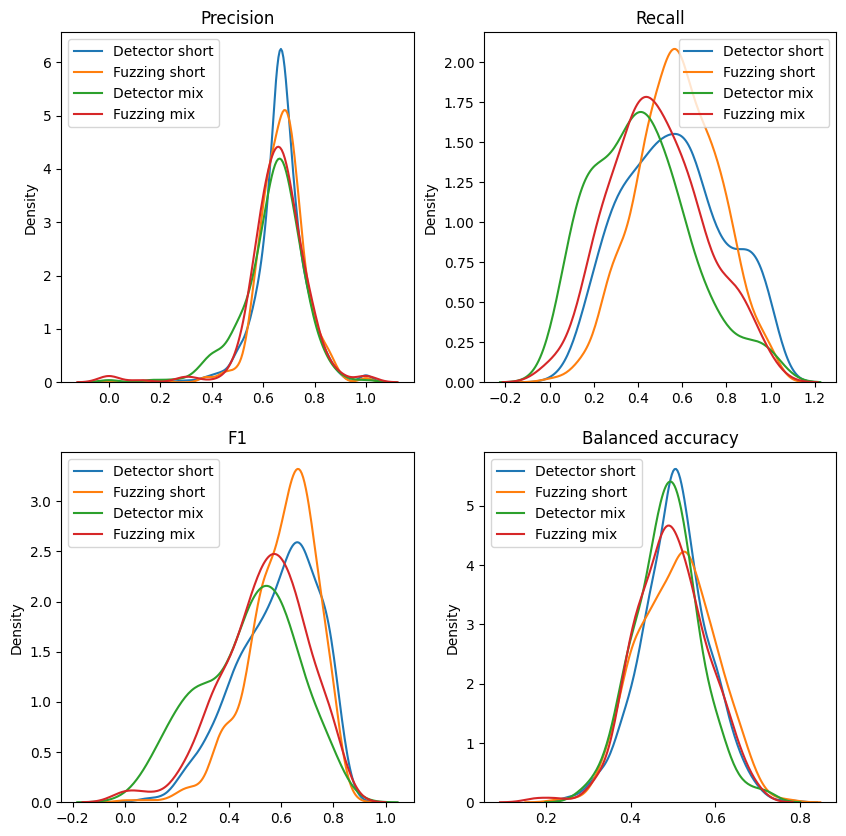

In [265]:
pqad, pqaf, id, ifu,cot_data = short_100
pqad_s, pqaf_s, id_s, ifu_s,simple_data = long_mix
fix,ax = plt.subplots(2,2,figsize=(10,10))
precision = [id["precision"],ifu["precision"],id_s["precision"],ifu_s["precision"]]
recall = [id["recall"],ifu["recall"],id_s["recall"],ifu_s["recall"]]
f1 = [id["f1"],ifu["f1"],id_s["f1"],ifu_s["f1"]]
labels= ["Detector short","Fuzzing short","Detector mix","Fuzzing mix"]
balanced_accuracy = [id["balanced_accuracy"],ifu["balanced_accuracy"],id_s["balanced_accuracy"],ifu_s["balanced_accuracy"]]
for i in range(4):
    sns.kdeplot(precision[i],ax=ax[0][0],label=labels[i])
ax[0][0].set_title("Precision")
ax[0][0].legend()
for i in range(4):
    sns.kdeplot(recall[i],ax=ax[0][1],label=labels[i])
ax[0][1].set_title("Recall")
ax[0][1].legend()
for i in range(4):
    sns.kdeplot(f1[i],ax=ax[1][0],label=labels[i])
ax[1][0].set_title("F1")
ax[1][0].legend()
for i in range(4):
    sns.kdeplot(balanced_accuracy[i],ax=ax[1][1],label=labels[i])
ax[1][1].set_title("Balanced accuracy")
ax[1][1].legend()
plt.show()

# Distributions

In [222]:
import asyncio
from nnsight import LanguageModel 
from tqdm import tqdm
import torch
from sae_auto_interp.explainers import SimpleExplainer, ExplainerInput
from sae_auto_interp.clients import get_client
from sae_auto_interp.utils import execute_model, load_tokenized_data, get_samples
from sae_auto_interp.features import FeatureRecord
import random
from sae_auto_interp.experiments import sample_top_and_quantiles

In [240]:
model = LanguageModel("meta-llama/Meta-Llama-3-8B", device_map="cpu", dispatch=True,torch_dtype =torch.bfloat16)

# Load tokenized data
tokens = load_tokenized_data(model.tokenizer)
CONFIG.batch_len = 256
# Load features to explain
samples = get_samples(N_LAYERS=32,N_FEATURES=131072,N_SAMPLES=10000)

raw_features_path = "raw_features_llama"

/home/gpaulo/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [225]:
layer = 10

records = FeatureRecord.from_tensor(
    tokens,
    tokenizer=model.tokenizer,
    layer_index=layer,
    selected_features=samples[layer],
    raw_dir= raw_features_path,
    max_examples=10000
)


Loading features from tensor for layer 10: 100%|██████████| 162/162 [05:04<00:00,  1.88s/it]


In [227]:
from sae_auto_interp import cache_config as CONFIG


In [228]:

model = LanguageModel("openai-community/gpt2", device_map="cpu", dispatch=True,torch_dtype =torch.bfloat16)

# Load tokenized data
CONFIG.batch_len = 64
tokens = load_tokenized_data(model.tokenizer,CONFIG=CONFIG)


# Load features to explain
samples = get_samples()

raw_features_path = "raw_features"

In [ ]:
layer = 10

records = FeatureRecord.from_tensor(
    tokens,
    tokenizer=model.tokenizer,
    layer_index=layer,
    selected_features=samples[layer],
    raw_dir= raw_features_path,
    max_examples=10000
)